In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob

c:\Users\Fagan\anaconda3\envs\learn-env\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('bfro_reports_geocoded.csv')
df.head()

,observed,location_details,county,state,season,title,latitude,longitude,date,number,...,precip_intensity,precip_probability,precip_type,pressure,summary,conditions,uv_index,visibility,wind_bearing,wind_speed
0,I am not sure how relevant this report will be...,"We were on our way to Rapid City, so we were h...",Washakie County,Wyoming,Summer,NaN,NaN,NaN,NaN,798.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I don't know if what I saw was two bigfoots or...,"Heading to the deep mine Poca #2, the airshaft...",Wyoming County,West Virginia,Winter,Report 13237: Daylight sighting near an abando...,37.58135,-81.29745,2005-12-03,13237.0,...,0.204,100.0,"['rain', 'snow']",1018.7,Partly cloudy throughout the day with late aft...,"Snow, Rain, Partially cloudy",NaN,9.3,168.1,17.1
2,"My family and I went to Ludlow, Vermont for Co...",It's off Rt 100 outside of Ludlow Vermont. It ...,Windsor County,Vermont,Fall,Report 13285: Evening sighting by motorists on...,43.46540,-72.70510,2005-10-08,13285.0,...,3.208,100.0,['rain'],1011.8,Cloudy skies throughout the day with a chance ...,"Rain, Overcast",NaN,5.0,356.2,7.6
3,It was spring break 1984 and I was 16 at the t...,"Wythe county Virginia near Wytheville, looking...",Wythe County,Virginia,Spring,"Report 2285: Boy sees ""Bigfoot"" in the woods w...",37.22647,-81.09017,1984-04-08,2285.0,...,0.000,0.0,NaN,1020.9,Partly cloudy throughout the day.,Partially cloudy,NaN,13.0,107.3,11.5
4,It was the winter of 1996 and we were on our w...,"Hwy 182, Wood County Between Quitman, Texas an...",Wood County,Texas,Winter,Report 2048: Night time road crossing observation,32.79430,-95.54250,1996-12-22,2048.0,...,NaN,0.0,NaN,NaN,Partly cloudy throughout the day.,Partially cloudy,NaN,10.5,180.4,20.8


In [3]:
df.shape

(5082, 29)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   observed            5043 non-null   object 
 1   location_details    4319 non-null   object 
 2   county              5082 non-null   object 
 3   state               5082 non-null   object 
 4   season              5082 non-null   object 
 5   title               4104 non-null   object 
 6   latitude            4104 non-null   float64
 7   longitude           4104 non-null   float64
 8   date                4104 non-null   object 
 9   number              5082 non-null   float64
 10  classification      5082 non-null   object 
 11  geohash             4104 non-null   object 
 12  temperature_high    4102 non-null   float64
 13  temperature_mid     3964 non-null   float64
 14  temperature_low     4102 non-null   float64
 15  dew_point           3951 non-null   float64
 16  humidi

In [5]:
df.columns

Index(['observed', 'location_details', 'county', 'state', 'season', 'title',
       'latitude', 'longitude', 'date', 'number', 'classification', 'geohash',
       'temperature_high', 'temperature_mid', 'temperature_low', 'dew_point',
       'humidity', 'cloud_cover', 'moon_phase', 'precip_intensity',
       'precip_probability', 'precip_type', 'pressure', 'summary',
       'conditions', 'uv_index', 'visibility', 'wind_bearing', 'wind_speed'],
      dtype='object')

In [6]:
print(df['observed'].isna().sum())
print(df['classification'].isna().sum())

39
0


In [7]:
df['classification'].value_counts()

Class B    2550
Class A    2502
Class C      30
Name: classification, dtype: int64

In [8]:
df['observed'] = df['observed'].astype(str)

In [9]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['pos'], sentiment_scores['neu'], sentiment_scores['neg']

In [10]:
df['positive_score'], df['neutral_score'], df['negative_score'] = zip(*df['observed'].apply(get_sentiment_scores))
df.head()

,observed,location_details,county,state,season,title,latitude,longitude,date,number,...,pressure,summary,conditions,uv_index,visibility,wind_bearing,wind_speed,positive_score,neutral_score,negative_score
0,I am not sure how relevant this report will be...,"We were on our way to Rapid City, so we were h...",Washakie County,Wyoming,Summer,NaN,NaN,NaN,NaN,798.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032,0.931,0.038
1,I don't know if what I saw was two bigfoots or...,"Heading to the deep mine Poca #2, the airshaft...",Wyoming County,West Virginia,Winter,Report 13237: Daylight sighting near an abando...,37.58135,-81.29745,2005-12-03,13237.0,...,1018.7,Partly cloudy throughout the day with late aft...,"Snow, Rain, Partially cloudy",NaN,9.3,168.1,17.1,0.038,0.962,0.000
2,"My family and I went to Ludlow, Vermont for Co...",It's off Rt 100 outside of Ludlow Vermont. It ...,Windsor County,Vermont,Fall,Report 13285: Evening sighting by motorists on...,43.46540,-72.70510,2005-10-08,13285.0,...,1011.8,Cloudy skies throughout the day with a chance ...,"Rain, Overcast",NaN,5.0,356.2,7.6,0.053,0.928,0.019
3,It was spring break 1984 and I was 16 at the t...,"Wythe county Virginia near Wytheville, looking...",Wythe County,Virginia,Spring,"Report 2285: Boy sees ""Bigfoot"" in the woods w...",37.22647,-81.09017,1984-04-08,2285.0,...,1020.9,Partly cloudy throughout the day.,Partially cloudy,NaN,13.0,107.3,11.5,0.029,0.955,0.016
4,It was the winter of 1996 and we were on our w...,"Hwy 182, Wood County Between Quitman, Texas an...",Wood County,Texas,Winter,Report 2048: Night time road crossing observation,32.79430,-95.54250,1996-12-22,2048.0,...,NaN,Partly cloudy throughout the day.,Partially cloudy,NaN,10.5,180.4,20.8,0.052,0.925,0.023


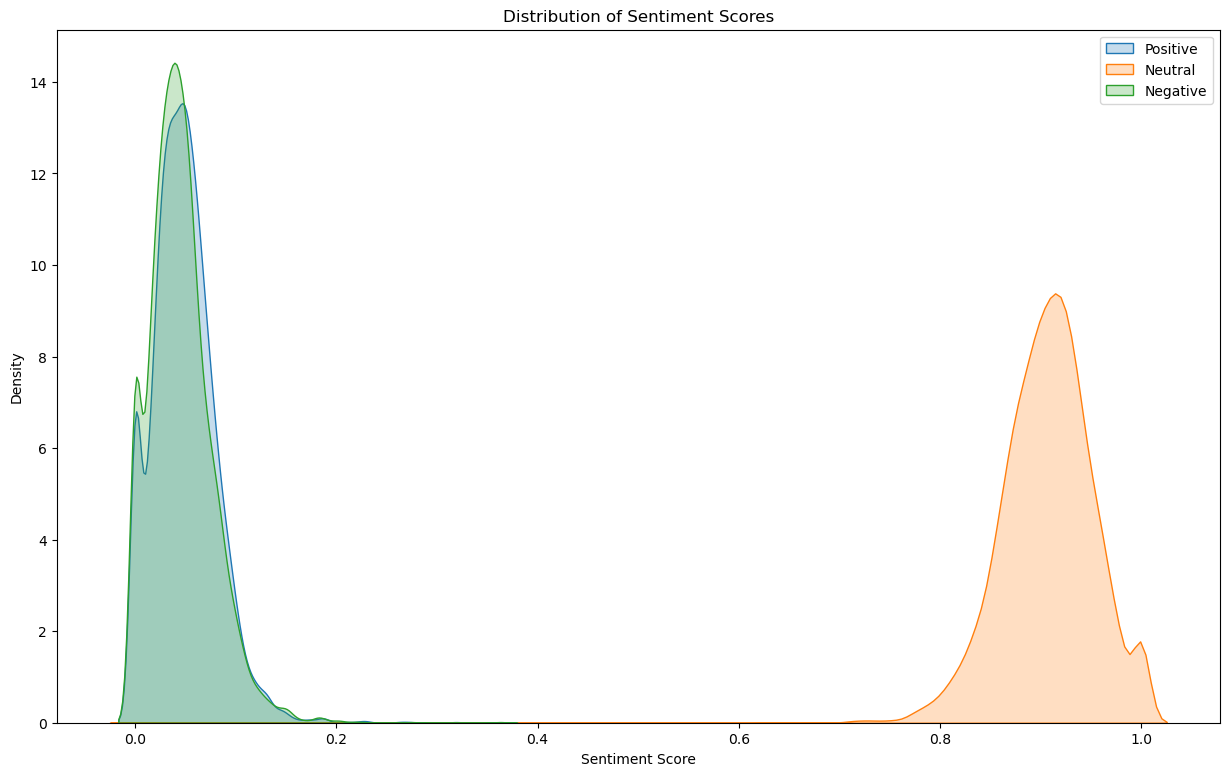

In [11]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=df, x='positive_score', label='Positive', shade=True)
sns.kdeplot(data=df, x='neutral_score', label='Neutral', shade=True)
sns.kdeplot(data=df, x='negative_score', label='Negative', shade=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Scores')
plt.legend()
plt.show()

In [12]:
# Define a function to calculate the sentiment polarity and subjectivity using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    return sentiment_polarity, sentiment_subjectivity

In [13]:
# Apply the get_sentiment function to the 'observed' column of the dataframe and create new columns for the sentiment polarity and subjectivity
df[['sentiment_polarity', 'sentiment_subjectivity']] = df['observed'].apply(lambda x: pd.Series(get_sentiment(x)))
df

,observed,location_details,county,state,season,title,latitude,longitude,date,number,...,conditions,uv_index,visibility,wind_bearing,wind_speed,positive_score,neutral_score,negative_score,sentiment_polarity,sentiment_subjectivity
0,I am not sure how relevant this report will be...,"We were on our way to Rapid City, so we were h...",Washakie County,Wyoming,Summer,NaN,NaN,NaN,NaN,798.0,...,NaN,NaN,NaN,NaN,NaN,0.032,0.931,0.038,0.113942,0.631838
1,I don't know if what I saw was two bigfoots or...,"Heading to the deep mine Poca #2, the airshaft...",Wyoming County,West Virginia,Winter,Report 13237: Daylight sighting near an abando...,37.58135,-81.29745,2005-12-03,13237.0,...,"Snow, Rain, Partially cloudy",NaN,9.3,168.1,17.1,0.038,0.962,0.000,0.007685,0.379021
2,"My family and I went to Ludlow, Vermont for Co...",It's off Rt 100 outside of Ludlow Vermont. It ...,Windsor County,Vermont,Fall,Report 13285: Evening sighting by motorists on...,43.46540,-72.70510,2005-10-08,13285.0,...,"Rain, Overcast",NaN,5.0,356.2,7.6,0.053,0.928,0.019,0.111702,0.351326
3,It was spring break 1984 and I was 16 at the t...,"Wythe county Virginia near Wytheville, looking...",Wythe County,Virginia,Spring,"Report 2285: Boy sees ""Bigfoot"" in the woods w...",37.22647,-81.09017,1984-04-08,2285.0,...,Partially cloudy,NaN,13.0,107.3,11.5,0.029,0.955,0.016,-0.005818,0.425516
4,It was the winter of 1996 and we were on our w...,"Hwy 182, Wood County Between Quitman, Texas an...",Wood County,Texas,Winter,Report 2048: Night time road crossing observation,32.79430,-95.54250,1996-12-22,2048.0,...,Partially cloudy,NaN,10.5,180.4,20.8,0.052,0.925,0.023,-0.039541,0.322959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,while camping protecting other equipment befor...,(withheld),Rio Arriba County,New Mexico,Summer,NaN,NaN,NaN,NaN,11992.0,...,NaN,NaN,NaN,NaN,NaN,0.000,0.958,0.042,0.076111,0.279444
5078,I was on my way to work on a Saturday morning ...,"Laurel, Maryland. It was sighted off of Rt 19...",Prince George's County,Maryland,Spring,NaN,NaN,NaN,NaN,1171.0,...,NaN,NaN,NaN,NaN,NaN,0.038,0.881,0.081,0.038747,0.275823
5079,On the twenty sixth and again on the twenty se...,"head n.on highway 441 from Orlando,then go eas...",Lake County,Florida,Summer,NaN,NaN,NaN,NaN,30267.0,...,NaN,NaN,NaN,NaN,NaN,0.017,0.983,0.000,-0.001304,0.289654
5080,I was hunting on me and my neighbor's property...,It was on my neighbor's property in the woods ...,White County,Illinois,Fall,NaN,NaN,NaN,NaN,59058.0,...,NaN,NaN,NaN,NaN,NaN,0.012,0.964,0.024,0.081796,0.542212


<AxesSubplot:xlabel='sentiment_polarity', ylabel='Count'>

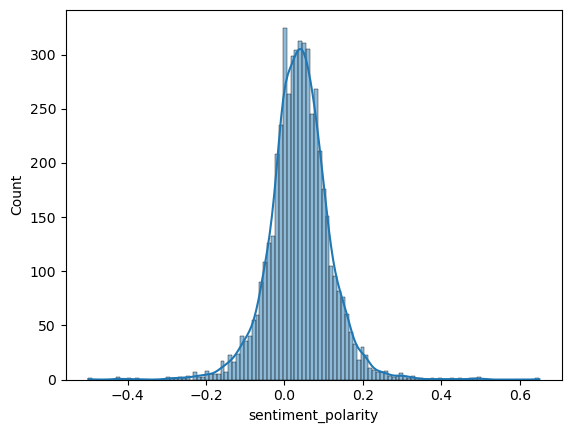

In [14]:
sns.histplot(df['sentiment_polarity'], kde=True)

<AxesSubplot:xlabel='sentiment_subjectivity', ylabel='Count'>

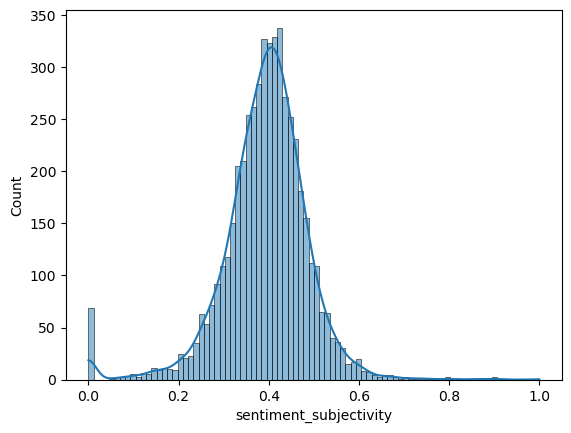

In [15]:
sns.histplot(df['sentiment_subjectivity'], kde=True)

In [16]:
# create preprocess_text function
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [17]:
df['observed'] = df['observed'].apply(preprocess_text)
df

,observed,location_details,county,state,season,title,latitude,longitude,date,number,...,conditions,uv_index,visibility,wind_bearing,wind_speed,positive_score,neutral_score,negative_score,sentiment_polarity,sentiment_subjectivity
0,"sure relevant report , however thought importa...","We were on our way to Rapid City, so we were h...",Washakie County,Wyoming,Summer,NaN,NaN,NaN,NaN,798.0,...,NaN,NaN,NaN,NaN,NaN,0.032,0.931,0.038,0.113942,0.631838
1,"n't know saw two bigfoot something else , one ...","Heading to the deep mine Poca #2, the airshaft...",Wyoming County,West Virginia,Winter,Report 13237: Daylight sighting near an abando...,37.58135,-81.29745,2005-12-03,13237.0,...,"Snow, Rain, Partially cloudy",NaN,9.3,168.1,17.1,0.038,0.962,0.000,0.007685,0.379021
2,"family went ludlow , vermont columbus day week...",It's off Rt 100 outside of Ludlow Vermont. It ...,Windsor County,Vermont,Fall,Report 13285: Evening sighting by motorists on...,43.46540,-72.70510,2005-10-08,13285.0,...,"Rain, Overcast",NaN,5.0,356.2,7.6,0.053,0.928,0.019,0.111702,0.351326
3,spring break 1984 16 time . dad brother trip v...,"Wythe county Virginia near Wytheville, looking...",Wythe County,Virginia,Spring,"Report 2285: Boy sees ""Bigfoot"" in the woods w...",37.22647,-81.09017,1984-04-08,2285.0,...,Partially cloudy,NaN,13.0,107.3,11.5,0.029,0.955,0.016,-0.005818,0.425516
4,winter 1996 way home church one sunday evening...,"Hwy 182, Wood County Between Quitman, Texas an...",Wood County,Texas,Winter,Report 2048: Night time road crossing observation,32.79430,-95.54250,1996-12-22,2048.0,...,Partially cloudy,NaN,10.5,180.4,20.8,0.052,0.925,0.023,-0.039541,0.322959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,camping protecting equipment feat starting . e...,(withheld),Rio Arriba County,New Mexico,Summer,NaN,NaN,NaN,NaN,11992.0,...,NaN,NaN,NaN,NaN,NaN,0.000,0.958,0.042,0.076111,0.279444
5078,"way work saturday morning 7 a.m. misty , foggy...","Laurel, Maryland. It was sighted off of Rt 19...",Prince George's County,Maryland,Spring,NaN,NaN,NaN,NaN,1171.0,...,NaN,NaN,NaN,NaN,NaN,0.038,0.881,0.081,0.038747,0.275823
5079,twenty sixth twenty seventh approximately 5:00...,"head n.on highway 441 from Orlando,then go eas...",Lake County,Florida,Summer,NaN,NaN,NaN,NaN,30267.0,...,NaN,NaN,NaN,NaN,NaN,0.017,0.983,0.000,-0.001304,0.289654
5080,hunting neighbor 's property right daylight . ...,It was on my neighbor's property in the woods ...,White County,Illinois,Fall,NaN,NaN,NaN,NaN,59058.0,...,NaN,NaN,NaN,NaN,NaN,0.012,0.964,0.024,0.081796,0.542212


In [25]:
# Drop rows with NaN in 'observed' and 'classification'
df.dropna(subset=['observed', 'classification'], inplace=True)
# Drop rows with 'classification' equal to Class C
df = df[df['classification'] != 'Class C']

In [32]:
# Create a pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=2000))
])

# Define the hyperparameters to tune
parameters = {
    'vect__max_df': [0.6, 0.7, 0.8],
    'vect__min_df': [0.01, 0.02, 0.03],
    'clf__C': [0.01, 0.1, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['observed'], df['classification'], test_size=0.2, random_state=42)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# Evaluate the performance of the best estimator on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification report:\n', classification_report(y_test, y_pred))


Best hyperparameters: {'clf__C': 0.01, 'vect__max_df': 0.6, 'vect__min_df': 0.01}
Best score: 0.795096623382981
Accuracy: 0.7655786350148368
Classification report:
               precision    recall  f1-score   support

     Class A       0.77      0.75      0.76       495
     Class B       0.77      0.78      0.77       516

    accuracy                           0.77      1011
   macro avg       0.77      0.77      0.77      1011
weighted avg       0.77      0.77      0.77      1011



In [33]:
pipeline

Pipeline(steps=[('vect', CountVectorizer()),
                ('clf', LogisticRegression(max_iter=2000))])

In [34]:
# Changing from count vectorizer to TF-IDF vectorizer
pipeline.steps[0] = ('vect', TfidfVectorizer())
pipeline

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(max_iter=2000))])

In [35]:
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# Evaluate the performance of the best estimator on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification report:\n', classification_report(y_test, y_pred))

Best hyperparameters: {'clf__C': 1.0, 'vect__max_df': 0.7, 'vect__min_df': 0.02}
Best score: 0.8054892973846209
Accuracy: 0.781404549950544
Classification report:
               precision    recall  f1-score   support

     Class A       0.78      0.77      0.78       495
     Class B       0.78      0.79      0.79       516

    accuracy                           0.78      1011
   macro avg       0.78      0.78      0.78      1011
weighted avg       0.78      0.78      0.78      1011



In [42]:
# Changing from Logistic Regression to XGBoost
pipeline.steps[1] = ('clf', XGBClassifier())

# Define the hyperparameters to tune
parameters = {
    'vect__max_df': [0.6, 0.7, 0.8],
    'vect__min_df': [0.01, 0.02, 0.03],
    'clf__learning_rate': [0.01, 0.1, 1.0],
    'clf__max_depth': [3, 5, 7],
    'clf__n_estimators': [50, 100, 200]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# Evaluate the performance of the best estimator on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification report:\n', classification_report(y_test, y_pred))

Best hyperparameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'vect__max_df': 0.6, 'vect__min_df': 0.01}
Best score: 0.8099432131099389
Accuracy: 0.7695351137487636
Classification report:
               precision    recall  f1-score   support

     Class A       0.76      0.77      0.77       495
     Class B       0.78      0.77      0.77       516

    accuracy                           0.77      1011
   macro avg       0.77      0.77      0.77      1011
weighted avg       0.77      0.77      0.77      1011



In [43]:
confusion_matrix(y_test, y_pred, labels=['Class A', 'Class B'])

array([[380, 115],
       [118, 398]], dtype=int64)

In [45]:
# Create a new DataFrame with rows where date is not missing
tsdf = df.dropna(subset=['date']).copy()

# Convert the date column to datetime and set it as the index
tsdf['date'] = pd.to_datetime(tsdf['date'])
tsdf.set_index('date', inplace=True)

# Sort the DataFrame by the index
tsdf.sort_index(inplace=True)

tsdf

,observed,location_details,county,state,season,title,latitude,longitude,number,classification,...,conditions,uv_index,visibility,wind_bearing,wind_speed,positive_score,neutral_score,negative_score,sentiment_polarity,sentiment_subjectivity
date,,,,,,,,,,,,,,,,,,,,,
1869-11-10,"article , titled `` wild man - ? `` , original...",NaN,Stanislaus County,California,Fall,Report 14338: Old newspaper article (Titusvill...,37.39555,-121.48710,14338.0,Class A,...,Partially cloudy,NaN,9.0,286.4,9.2,0.055,0.945,0.000,0.097273,0.455909
1921-01-14,nan,NaN,Clearfield County,Pennsylvania,Winter,Report 14358: Old newspaper article (Clearfiel...,41.01865,-78.37700,14358.0,Class A,...,Partially cloudy,NaN,6.4,259.0,11.0,0.000,1.000,0.000,0.000000,0.000000
1925-10-14,"today 's report bigfoot body , memory jarred s...",NaN,Avoyelles Parish,Louisiana,Fall,Report 24413: Woman recounts a tale her Grandf...,31.08774,-91.84467,24413.0,Class B,...,"Rain, Overcast",NaN,7.5,134.8,17.8,0.055,0.869,0.076,0.083333,0.283333
1930-09-30,second time listed report . two men lawyer hen...,"Leon County Texas, 1930's along the Trinity ri...",Leon County,Texas,Fall,Report 2477: Nine foot tall brown/black creatu...,31.40444,-95.70861,2477.0,Class B,...,Clear,NaN,9.9,288.6,21.9,0.065,0.876,0.059,-0.022245,0.358903
1937-08-16,nan,NaN,Warrick County,Indiana,Summer,Report 14336: Old newspaper article (The Hammo...,38.01000,-87.32030,14336.0,Class A,...,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,without doubt bigfoot chito nature preserve ’ ...,Chito Nature Preserve - there are tens of thou...,Hillsborough County,Florida,Winter,Report 75271: Possible howls 20 miles SE of Ta...,27.82074,-82.16940,75271.0,Class B,...,Partially cloudy,6.0,7.1,17.5,4.8,0.039,0.889,0.072,-0.021071,0.479762
2022-12-17,heard strange “ mournful howling ” ( ’ heard d...,"Whitestone Dr, Canton GA [Investigator (MM) no...",Cherokee County,Georgia,Winter,Report 75283: RECENT !! Property owner reports...,34.17351,-84.46456,75283.0,Class B,...,Partially cloudy,5.0,9.9,260.0,13.7,0.056,0.889,0.056,-0.012000,0.461667
2022-12-20,shortly dawn back porch coffee watching dog le...,"Shady Drive, off of Warren Road",Indiana County,Pennsylvania,Winter,Report 75305: Possible trackway found and phot...,40.60756,-79.20052,75305.0,Class B,...,Partially cloudy,4.0,9.9,356.8,4.7,0.016,0.934,0.050,0.017454,0.299577


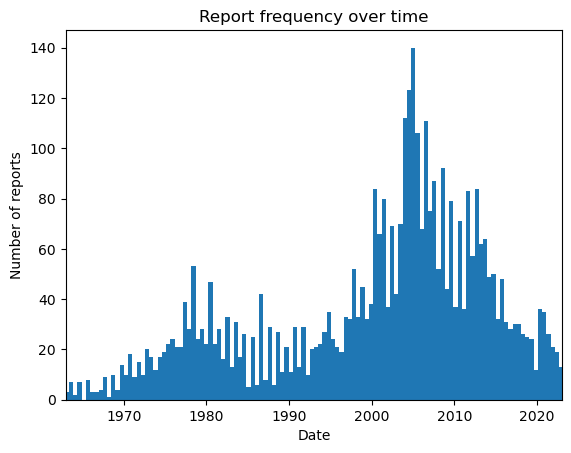

In [50]:
plt.hist(tsdf.index, bins=300)
plt.xlim('1963', '2023')
plt.xlabel('Date')
plt.ylabel('Number of reports')
plt.title('Report frequency over time')
plt.show()

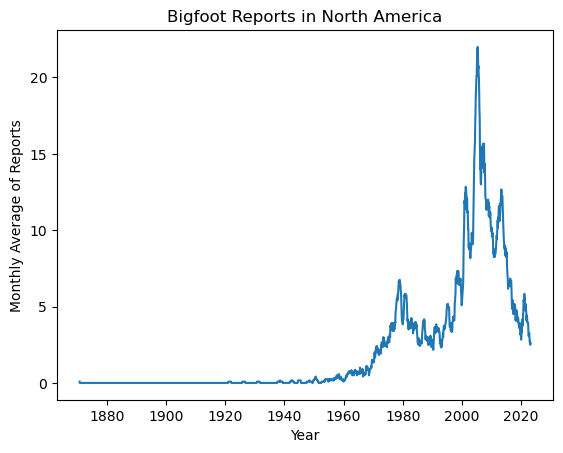

In [52]:
# Count the number of reports per month
monthly_counts = tsdf.resample('M').count()['observed']

# Calculate the rolling monthly average with a window of 12 months
rolling_avg = monthly_counts.rolling(window=12).mean()

# Plot the rolling monthly average
plt.plot(rolling_avg)
plt.xlabel('Year')
plt.ylabel('Monthly Average of Reports')
plt.title('Bigfoot Reports in North America')
plt.show()

In [53]:
# Extract the month from the index of tsdf and count the occurrences of each month
common_months = tsdf.index.month.value_counts()

# Print the most common month
print(f"The most common month is {common_months.index[0]}, with {common_months.iloc[0]} occurrences.")

The most common month is 10, with 550 occurrences.
